<h1 align="center"> Energy demand (Electricity price) Forecasting </h1>
<h2> Methods used in this project : </h2>
<h3> 1. Machine learning : </h3>
<ul>    
<li> XGboost Regressor </li>
</ul>
<h3> 2. Deep learning/Stacked models : </h3>
<ul>    
<li> GRU </li>
<li> LSTM </li>
<li> CNN </li>
<li> CNN-LSTM </li>
<li> LSTM-Attention </li>
</ul>
<h3> 3. Hybrid methods: </h3>
<ul>    
<li> GRU-XGBoost </li>
<li> LSTM-Attention-XGBoost </li>
</ul>


In [2]:
# pip install plotly

# tensorflow-addons version depends on the tensorflow and python version of the system,
# you can find the compatibility in this link

# https://stackoverflow.com/questions/61380552/unable-to-import-tensorflow-addons
# !pip install tensorflow-addons==0.19.0

In [3]:
!pip install keras==2.9
!pip install tensorflow==2.8.2
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.5 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 211.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 13.1 MB/s e

In [4]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
import tensorflow_addons as tfa


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

## Import data

In [5]:
ROOT = '/kaggle/input/elmy-ens'
TRAIN_INPUT = ROOT + "/x_train.csv"
TRAIN_OUTPUT = ROOT + "/y_train.csv"
TEST_INPUT = ROOT + "/x_test.csv"

x_train_raw = pd.read_csv(TRAIN_INPUT, index_col= 'DELIVERY_START', parse_dates=True)
y_train_raw = pd.read_csv(TRAIN_OUTPUT, index_col= 'DELIVERY_START', parse_dates=True)
x_test_raw = pd.read_csv(TEST_INPUT, index_col= 'DELIVERY_START', parse_dates=True)
#datetime data
x_train = x_train_raw.set_index(pd.to_datetime(x_train_raw.index, utc=True))
y_train = y_train_raw.set_index(pd.to_datetime(y_train_raw.index, utc=True))
x_test = x_test_raw.set_index(pd.to_datetime(x_test_raw.index, utc=True))

In [6]:
WEATHER_PATH = ROOT + "/donnees-synop-essentielles-omm.csv"
weather = pd.read_csv(WEATHER_PATH, encoding="ISO-8859-1", sep=';', parse_dates=True)

In [7]:
to_drop = ['Temps prÃ©sent', 'Temps passÃ© 1',
       'Temps passÃ© 2', 'NebulositÃ© totale',
       "NÃ©bulositÃ©  des nuages de l' Ã©tage infÃ©rieur",
       "Hauteur de la base des nuages de l'Ã©tage infÃ©rieur",
       "Type des nuages de l'Ã©tage infÃ©rieur",
       "Type des nuages de l'Ã©tage moyen",
       "Type des nuages de l'Ã©tage supÃ©rieur",'GÃ©opotentiel','MÃ©thode de mesure TempÃ©rature du thermomÃ¨tre mouillÃ©','TempÃ©rature du thermomÃ¨tre mouillÃ©',
       'Rafale sur les 10 derniÃ¨res minutes', 'Rafales sur une pÃ©riode',
       'Periode de mesure de la rafale', 'Etat du sol',  'Periode de mesure de la neige fraiche', 'NÃ©bulositÃ© couche nuageuse 1', 'Type nuage 1', 'Hauteur de base 1',
       'NÃ©bulositÃ© couche nuageuse 2', 'Type nuage 2', 'Hauteur de base 2',
       'NÃ©bulositÃ© couche nuageuse 3', 'Type nuage 3', 'Hauteur de base 3',
       'NÃ©bulositÃ© couche nuageuse 4', 'Type nuage 4', 'Hauteur de base 4',
       'Coordonnees', 'Nom', 'Type de tendance baromÃ©trique.1',
       'Temps passÃ© 1.1', 'Temps prÃ©sent.1', 'TempÃ©rature',
       'TempÃ©rature minimale sur 12 heures',
       'TempÃ©rature minimale sur 24 heures',
       'TempÃ©rature maximale sur 12 heures',
       'TempÃ©rature maximale sur 24 heures',
       'TempÃ©rature minimale du sol sur 12 heures', 'Latitude',
       'Longitude', 'Altitude', 'communes (name)', 'communes (code)',
       'EPCI (name)', 'EPCI (code)', 'department (name)', 'department (code)',
       'region (name)', 'region (code)', 'mois_de_l_annee','ï»¿ID OMM station']
weather.drop(to_drop, axis=1, inplace=True)

In [8]:
dict_renaming = { 'Date':'date', 'Pression au niveau mer':'pression',
       'Variation de pression en 3 heures':'pression_var', 'Type de tendance baromÃ©trique':'type_trend_barometrique',
       'Direction du vent moyen 10 mn':'direction_vent', 'Vitesse du vent moyen 10 mn':'vitesse_vent',
       'TempÃ©rature (Â°C)':'temperature', 'Point de rosÃ©e':'point_rosee', 'HumiditÃ©':'humidity',
       'VisibilitÃ© horizontale':'visibility','Pression station':'pression_station',
       'Niveau baromÃ©trique':'niveau_barometrique',
       'Variation de pression en 24 heures' :'pression_var_24h',
       'TempÃ©rature minimale sur 12 heures (Â°C)':'temperature_max_24h',
       'TempÃ©rature minimale sur 24 heures (Â°C)':'temperature_min_24h',
       'TempÃ©rature maximale sur 12 heures (Â°C)':'temperature_max_12h',
       'TempÃ©rature maximale sur 24 heures (Â°C)':'temperature_min_12h',
       'TempÃ©rature minimale du sol sur 12 heures (en Â°C)':'temperature_min_sol_12h',
        'Hauteur totale de la couche de neige, glace, autre au sol':'hauteur_neige_etc',
       'Hauteur de la neige fraÃ®che':'hauteur_neige',
       'PrÃ©cipitations dans la derniÃ¨re heure':'pluie_1h',
       'PrÃ©cipitations dans les 3 derniÃ¨res heures':'pluie_3h',
       'PrÃ©cipitations dans les 6 derniÃ¨res heures':'pluie_6h',
       'PrÃ©cipitations dans les 12 derniÃ¨res heures':'pluie_12h',
       'PrÃ©cipitations dans les 24 derniÃ¨res heures':'pluie_24h',
       'PhÃ©nomÃ¨ne spÃ©cial 1':'phenomene_special_1', 'PhÃ©nomÃ¨ne spÃ©cial 2':'phenomene_special_2',
       'PhÃ©nomÃ¨ne spÃ©cial 3':'phenomene_special_3', 'PhÃ©nomÃ¨ne spÃ©cial 4':'phenomene_special_4',
      }

In [9]:
weather.rename(columns=dict_renaming, inplace=True)

In [10]:
weather_france = weather.groupby('date').mean()

In [11]:
weather_france.dropna(axis=1, how='any', inplace=True)

In [12]:
weather_france.set_index(pd.to_datetime(weather_france.index, utc=True),inplace=True)


In [13]:
weather_france.describe()

,pression,pression_var,type_trend_barometrique,direction_vent,vitesse_vent,point_rosee,humidity,visibility,pression_station,pression_var_24h,hauteur_neige_etc,pluie_1h,pluie_3h,pluie_6h,pluie_24h,temperature
count,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000
mean,101614.757633,20.392354,4.300770,173.900154,4.174248,284.313425,74.595308,26449.656904,100047.093835,5.035331,0.000161,0.102527,0.314660,0.636067,2.554485,16.299107
std,518.479402,58.737542,1.166127,32.479659,0.955502,3.846286,10.014382,5490.671597,496.842180,312.464255,0.000844,0.129752,0.335646,0.604331,1.814201,5.080552
min,99034.727273,-351.052632,1.396552,90.677966,2.242105,272.238000,40.216667,10458.444444,97465.789474,-1373.214286,-0.000606,-0.016364,-0.011111,-0.003571,0.078182,2.514894
25%,101342.090367,-17.034483,3.338983,148.166667,3.467227,281.522632,67.660866,22824.393720,99794.609564,-181.516746,0.000000,0.014286,0.078947,0.200000,1.190852,12.501695
50%,101619.473684,21.034483,4.237288,173.275862,4.033333,284.824545,76.933333,26344.285714,100070.666667,-3.793103,0.000000,0.055172,0.210169,0.463158,2.132143,16.326667
75%,101888.829545,57.521930,5.258621,198.461426,4.728573,287.495690,82.786885,30126.081901,100322.163743,183.874269,0.000000,0.141379,0.444448,0.894782,3.503571,19.893291
max,103214.615385,258.771930,7.033898,271.509434,9.380357,291.896552,90.896552,44794.772727,101536.101695,1119.122807,0.040000,1.277966,5.005455,6.898148,13.123077,31.350000


## Data cleaning : missing values

All columns except `predicted_spot_price` : 

In [14]:
#UTILITY FUNCTION
def build_matrix_harmonic_reg(freqs, time_array):
    A_matrix = np.array([(np.cos(2 * np.pi * fi * time_array), np.sin(2 * np.pi * fi * time_array)) for fi in freqs])
    A_matrix = A_matrix.reshape(len(freqs)*2,-1)
    A_matrix = np.vstack((A_matrix, np.array([np.ones(time_array.size)])))
    A_matrix = A_matrix.T
    return A_matrix
#UTILITY FUNCTION
from scipy.signal import argrelmax, periodogram

def get_largest_local_max(
    signal1D: np.ndarray, n_largest: int = 3, order: int = 1) -> [np.ndarray, np.ndarray]:
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_indexes = all_local_max_indexes[all_local_max.argsort()[::-1]][
        :n_largest
    ]

    return (
        np.take(signal1D, largest_local_max_indexes),
        largest_local_max_indexes,
    )
# function to partition a time series into intervals of NaNs and intervals of non-NaNs
def partition_na(column):
    '''
    Input :
        column (pd.Series with a datetime-like index)
    Returns : 
        null_patches (list) : list of intervals (list of consecutive points)
        
    '''
    null_indices = column[column.isnull()].index
    null_patches = []
    patch = [null_indices[0]]
    assert len(null_indices)>0
    for i in range(1,len(null_indices)):
        if null_indices[i] != null_indices[i-1]+pd.Timedelta('1h'):
            null_patches.append(patch)
            patch = [null_indices[i]]
        else:
            patch.append(null_indices[i])
    null_patches.append(patch)
    non_null_patches = []
    for i in range(len(null_patches)+1):
        # non_null interval situated directly on the left of the current null interval
        if i==0:
            if null_patches[i][0]==column.index[0]: #column starts with a NaN
                nan_first = True
                continue
            else:
                nan_first = False
                l1 = column.index[0]
                l2 = null_patches[i][-1] - pd.Timedelta('1h')           
        elif i==len(null_patches):
            if null_patches[i-1][-1]==column.index[-1]: #column ends with a NaN
                nan_last = True
                continue
            else:
                nan_last = False
                l1 = null_patches[i-1][-1] + pd.Timedelta('1h')
                l2 = column.index[-1]
        else:
            l1 = null_patches[i-1][-1] + pd.Timedelta('1h')
            l2 = null_patches[i][0] - pd.Timedelta('1h')
        if len(list((column[l1:l2])))>10:
            non_null_patches.append(list((column[l1:l2]).index))
        
    return null_indices, null_patches, non_null_patches, nan_first, nan_last
def relu(x):
    if x<0 :
        return 0
    else:
        return x
def get_hours_from_date(time_index, date):
    # Convert the datetime column into timedelta relative to the given date
    time_delta = time_index - date
    # Convert timedelta to hours (as integers)
    hours = time_delta.total_seconds() // 3600  # 3600 seconds in an hour
    # Convert Hours column to a list of integers
    hours_list = np.array(hours.astype(int).tolist())
    return hours_list
# function to perform missing values imputation
def impute_na(df, plot=False, trend_degree=9, seasonality_nb_freqs=4, exclude=None):
    '''
    Returns :
        df_imputed (DataFrame) : df resampled at '1h' intervals, without NaNs
        original_df_indices (ndarray) : indices of rows in `df_imputed` mapping to original df rows
    '''
    df_temp = df.copy()
    df_temp['original'] = 1
    df_temp = df_temp.resample('1h').mean()
    original_df_indices = np.where(df_temp['original'] == 1)[0]
    original_df_indices = df_temp.index[original_df_indices]
    na_columns = df_temp.columns[df_temp.isna().sum()>0]
    cols_to_drop = ['original']
    for column in na_columns:
#         print('COLUMN : ', column)
        if column != exclude:
            try:
                # Get trend of column signal
                signal = df_temp[column].interpolate()
                time_array = np.arange(len(signal.index))
                coeffs = np.polyfit(time_array, signal, trend_degree)
                approx_poly_trend = np.polyval(coeffs, time_array)
                df_temp[f'trend_{column}'] = approx_poly_trend
                cols_to_drop.append(f'trend_{column}')

                null_indices, null_patches, non_null_patches, _, _ = partition_na(df_temp[column])
                for i in range(len(null_patches)):
                    # Get local seasonality (from signal on the left or on the right )
                    if (len(null_patches) > len(non_null_patches)) and i==len(null_patches)-1:
                        non_null_interval = non_null_patches[i-1]
                    else:
                        non_null_interval = non_null_patches[i]

                    signal = (df_temp[column][non_null_interval] - df_temp[f'trend_{column}'][non_null_interval]).interpolate()
                    time_array = np.arange(signal.size)
                    fft_values = np.fft.fft(signal) 
                    frequencies = np.fft.fftfreq(len(signal), 3600)
                    # positive_freqs = frequencies[:len(frequencies)//2]
                    magnitude_spectrum = np.abs(fft_values[:len(fft_values)//2])
                    max_freq, max_freq_idx =get_largest_local_max(magnitude_spectrum, n_largest=seasonality_nb_freqs)
                    freqs = frequencies[max_freq_idx]*3600 #in H^{-1}
                    A_matrix = build_matrix_harmonic_reg(freqs, time_array)
                    reg_coeffs = np.linalg.lstsq(A_matrix, signal, rcond=None)[0]
                    hours_list = get_hours_from_date(df_temp.loc[null_patches[i],:].index, signal.index[0])
                    A_matrix_na = build_matrix_harmonic_reg(freqs, hours_list)
                    df_temp.loc[null_patches[i], column] = df_temp.loc[null_patches[i], f'trend_{column}'] + A_matrix_na @ reg_coeffs
                    df_temp.loc[null_patches[i], column] = df_temp.loc[null_patches[i], column].apply(relu)
                if plot:
                    plt.figure(figsize=(30,5))
                    plt.plot(df_temp[column])
                    for patch in null_patches:
                        plt.plot(df_temp.loc[patch,column], color='red')
                    plt.title(f'{column}')
            except:
#                 print(f"Could not decompose {column} into trend/seasonality, doing simple interpolation")
                null_indices, null_patches, non_null_patches, _, _ = partition_na(df_temp[column])
                df_temp[column] = df_temp[column].fillna(method = 'ffill')

                if plot:
                    plt.figure(figsize=(30,5))
                    plt.plot(df_temp[column])
                    for patch in null_patches:
                        plt.plot(df_temp.loc[patch,column], color='red')
                    plt.title(f'{column}')
    df_temp.drop(cols_to_drop, axis=1, inplace=True)
    return df_temp, original_df_indices
x_train_imputed, original_x_train_indices = impute_na(x_train,exclude='predicted_spot_price')
x_test_imputed, original_x_test_indices = impute_na(x_test)

/tmp/ipykernel_33/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')
/tmp/ipykernel_33/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')
/tmp/ipykernel_33/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


mean 1.4877309697001535
std spot_id_delta    40.941808
dtype: float64


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning:

The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



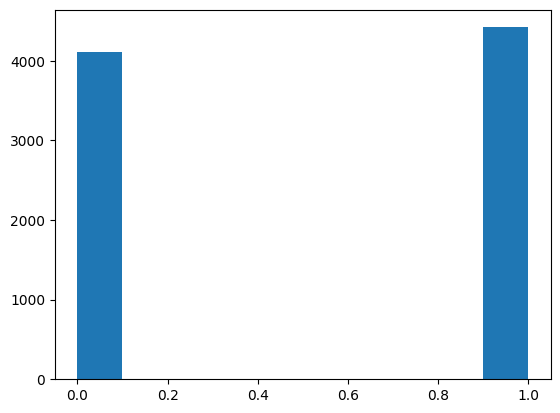

In [400]:
plt.hist((y_train.loc['2022-04-01':'2023-10-24']>0).astype(int))
print('mean', np.mean(y_train.loc['2022-04-01':'2023-10-24']))
print('std', np.std(y_train.loc['2022-04-01':'2023-10-24']))


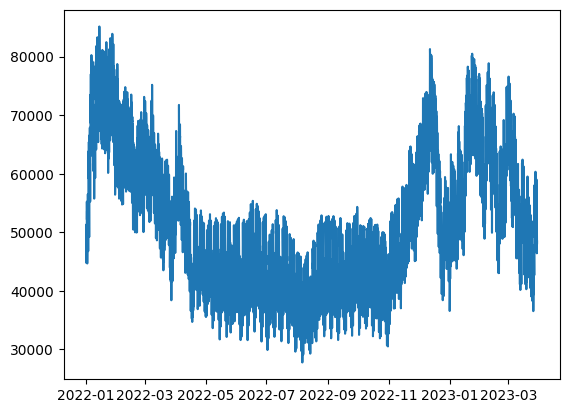

In [15]:
#NEW
null_indices, null_patches, non_null_patches, _, _ = partition_na(x_train['load_forecast'])
longest_patch = sorted(null_patches, key=lambda x:len(x),reverse=True)[0]    
x_train_imputed.loc[pd.DatetimeIndex(longest_patch),'load_forecast'] = x_test_imputed.loc[pd.DatetimeIndex(longest_patch).map(lambda dt: dt.replace(year=2023)),'load_forecast'].values
plt.plot(x_train_imputed['load_forecast'])

`predicted_spot_price` will be learned from available data for training data

In [16]:
x_train_test = pd.concat((x_train,x_test), axis=0)
x_imputed, _ = impute_na(x_train_test)

/tmp/ipykernel_33/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')
/tmp/ipykernel_33/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')
/tmp/ipykernel_33/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


In [17]:
null_indices = x_imputed.loc[x_imputed['predicted_spot_price'].isna()].index
non_null_indices = [i for i in x_imputed.index if i not in null_indices]

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_spot = x_imputed.loc[non_null_indices,:].drop('predicted_spot_price',axis=1)
y_spot = x_imputed.loc[non_null_indices,'predicted_spot_price']

# Split the data into training and testing sets
X_train_spot, X_test_spot, y_train_spot, y_test_spot = train_test_split(x_spot, y_spot, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xgb_reg = XGBRegressor(objective='reg:squarederror')

# Fit the model on the training data
xgb_reg.fit(X_train_spot, y_train_spot)

# Make predictions on the testing data
y_pred = xgb_reg.predict(X_test_spot)

y_test_with_no_zeros = y_test_spot.replace(0, np.nan)

# Calculate the absolute error
absolute_error = np.abs(y_pred - y_test_with_no_zeros)

# Calculate the relative error
relative_error = absolute_error / y_test_with_no_zeros

# Calculate the mean relative error, excluding any infinite or NaN values due to division by zero
mean_relative_error = np.mean(relative_error.replace([np.inf, -np.inf], np.nan).dropna())

print(f"Mean Relative Error: {mean_relative_error * 100:.2f}%")


Mean Relative Error: 11.22%


In [19]:
null_indices = x_train_imputed.loc[x_train_imputed['predicted_spot_price'].isna()].index

In [20]:
y_pred = xgb_reg.predict(x_train_imputed.drop('predicted_spot_price',axis=1).loc[null_indices,X_train_spot.columns])

In [21]:
x_train_imputed.loc[null_indices, 'predicted_spot_price'] = y_pred

<Axes: xlabel='DELIVERY_START'>

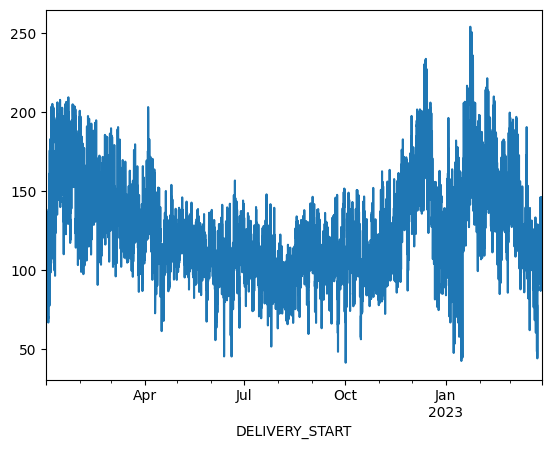

In [22]:
x_train_imputed['predicted_spot_price'].plot()

<Axes: xlabel='DELIVERY_START'>

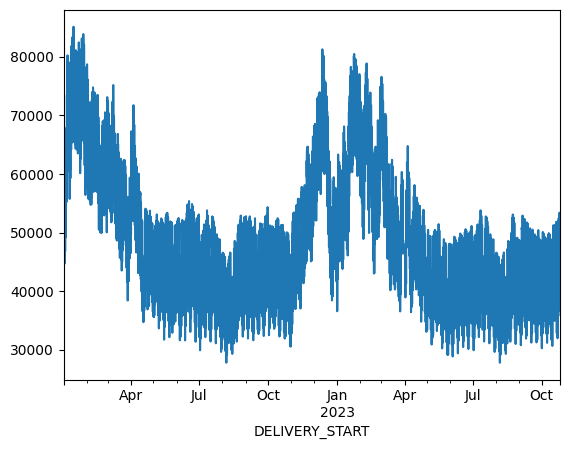

In [23]:
x_train_transition_test = pd.concat((x_train_imputed,x_test_imputed),axis=0).resample('1h').mean().interpolate()
x_train_transition_test['load_forecast'].plot()

In [24]:
y_train_resampled = y_train.resample('1h').mean().fillna(0)
xy_train_resampled = pd.concat((x_train_imputed,y_train_resampled),axis=1)

<strong> Feature Correlation </strong>

In [25]:
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15,12))
    #plot heat map
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')
    
    return plt.show()

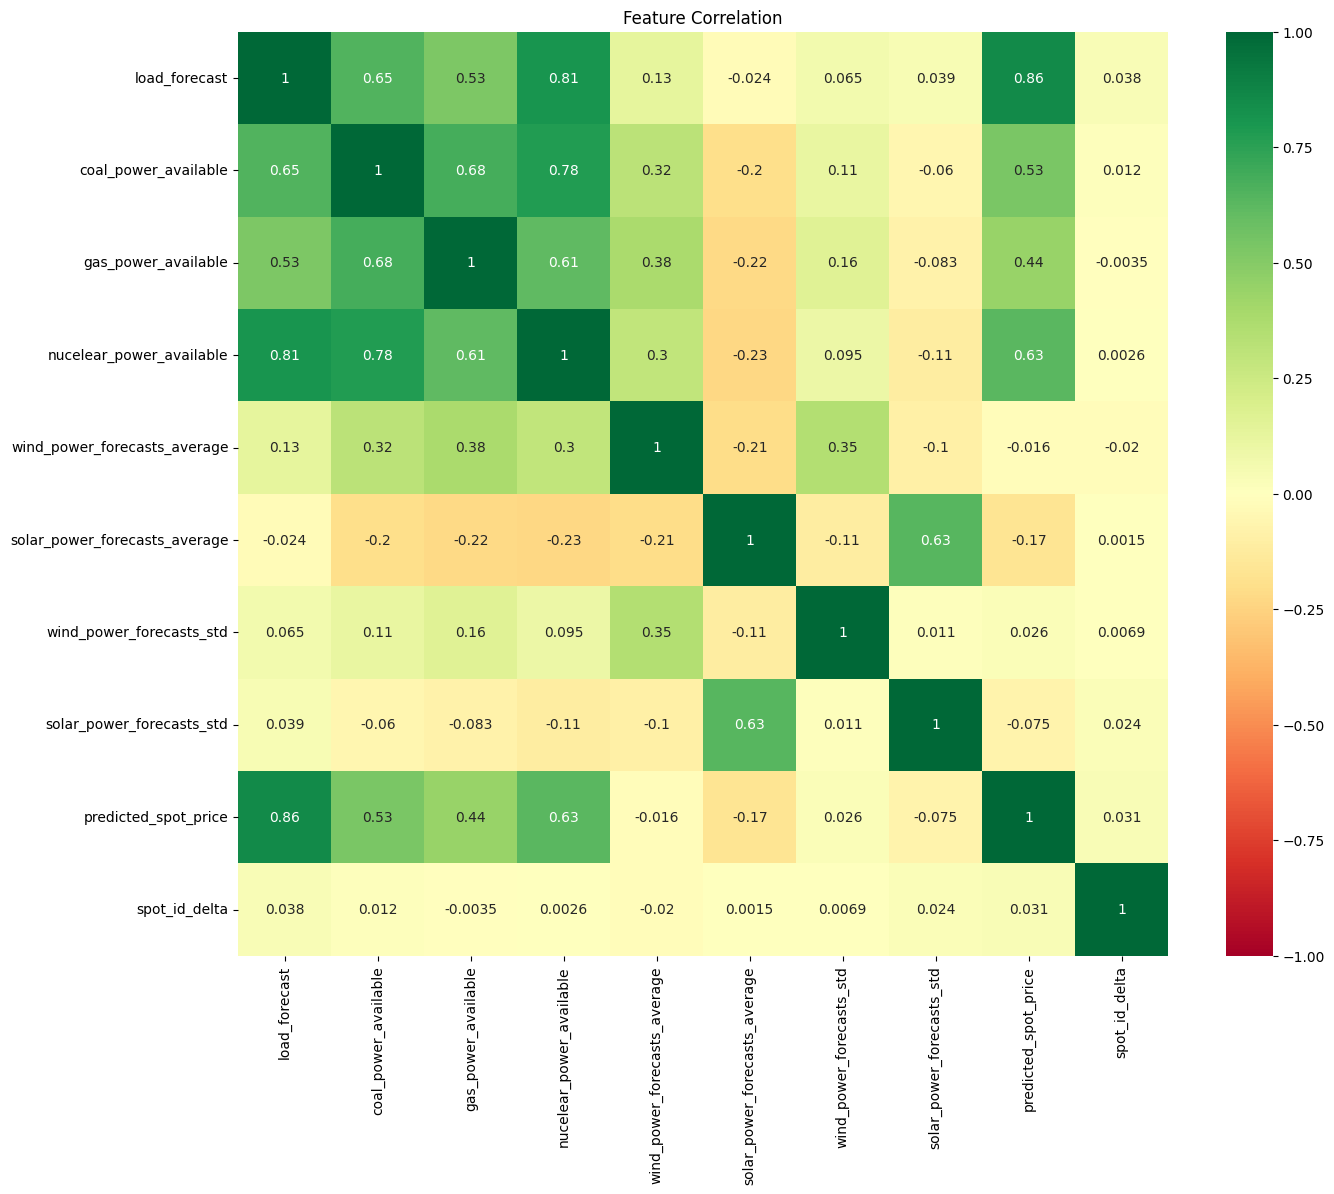

In [26]:
feat_corr(xy_train_resampled)

<h3> Weather dataset </h3>

In [27]:
weather_france = weather_france.resample('1h').mean().interpolate()

In [28]:
weather_y_train = pd.concat((weather_france.loc[x_train_imputed.index,:],y_train_resampled['spot_id_delta']),axis=1)

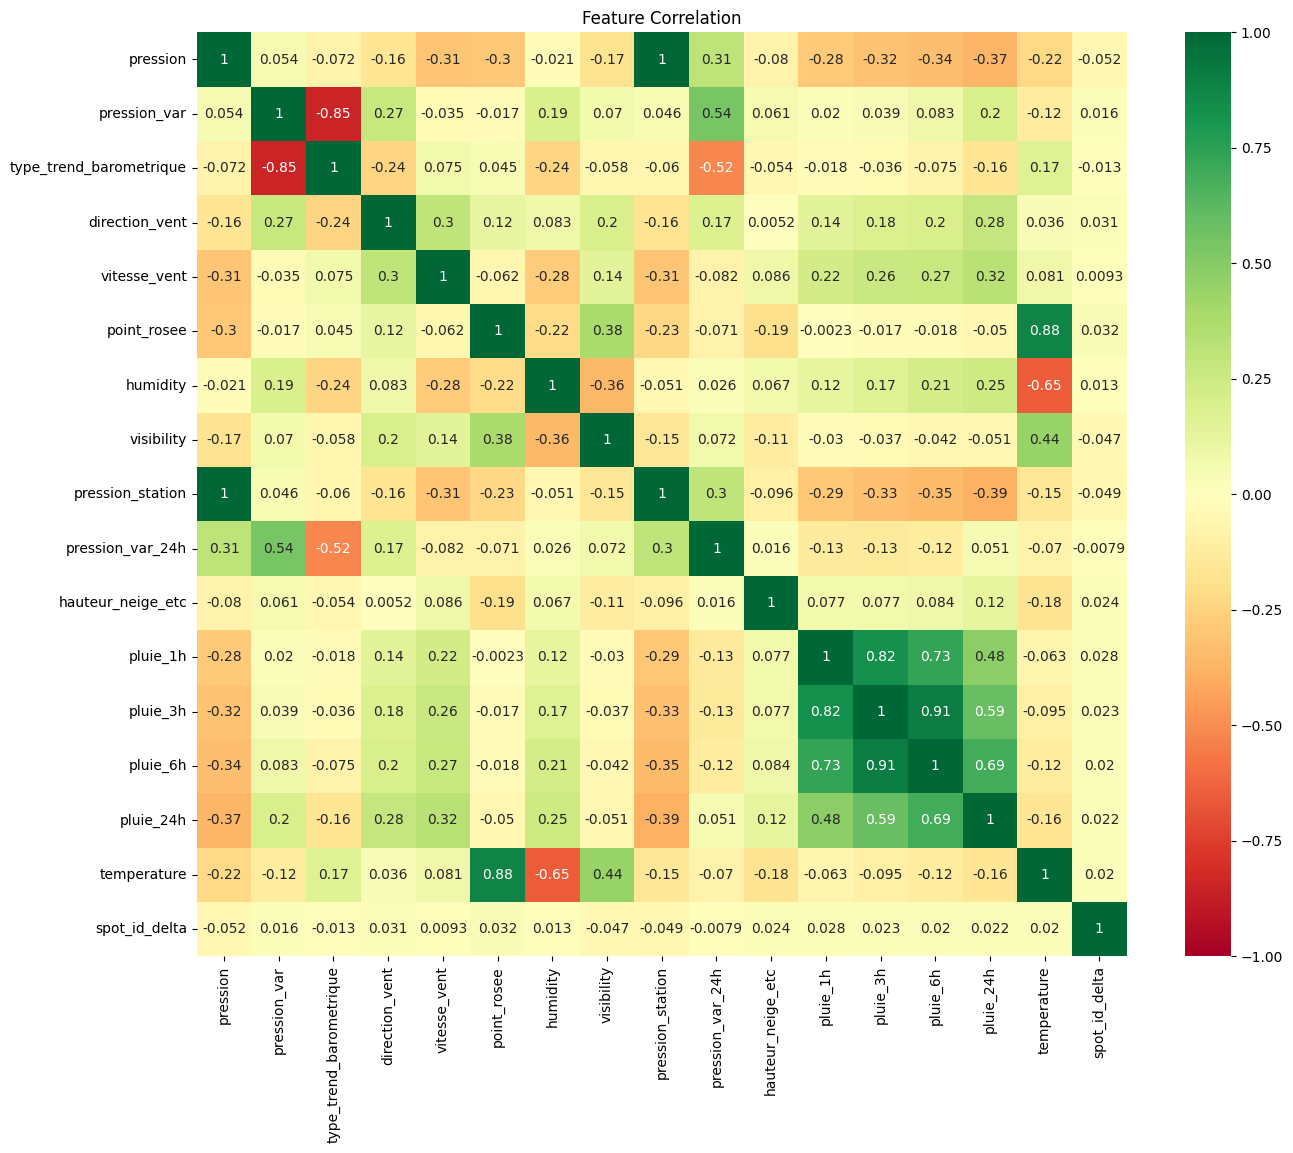

In [29]:
feat_corr(weather_y_train)

In [30]:
to_drop_weather = ['type_trend_barometrique','pression_station','point_rosee']
weather_france.drop(to_drop_weather, axis=1, inplace=True)

In [31]:
x_train_we = pd.concat((x_train_imputed,weather_france.loc[x_train_imputed.index,:]),axis=1) #we=weather_energy
x_test_we = pd.concat((x_test_imputed,weather_france.loc[x_test_imputed.index,:]),axis=1) 
x_train_transition_test_we = pd.concat((x_train_transition_test,weather_france.loc[x_train_transition_test.index,:]),axis=1) 

In [32]:
# JOURNEES SPECIALES -----------------------------------------
#Monday, Saturday, Sunday
x_train_we['monday'] = (x_train_we.index.dayofweek == 0).astype(int)
x_train_we['saturday'] = (x_train_we.index.dayofweek == 5).astype(int)
x_train_we['sunday'] = (x_train_we.index.dayofweek == 6).astype(int)

x_test_we['monday'] = (x_test_we.index.dayofweek == 0).astype(int)
x_test_we['saturday'] = (x_test_we.index.dayofweek == 5).astype(int)
x_test_we['sunday'] = (x_test_we.index.dayofweek == 6).astype(int)

x_train_transition_test_we['monday'] = (x_train_transition_test_we.index.dayofweek == 0).astype(int)
x_train_transition_test_we['saturday'] = (x_train_transition_test_we.index.dayofweek == 5).astype(int)
x_train_transition_test_we['sunday'] = (x_train_transition_test_we.index.dayofweek == 6).astype(int)

In [33]:
!pip install suntimes

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [34]:
# SUNLIGHT -----------------------------------------------------------
from datetime import datetime
from suntimes import SunTimes  
paris = SunTimes(2.349902, 48.852968, 35)

x_train_we['sunrise'] = x_train_we.index.map(lambda x: paris.riseutc(x))
x_train_we['sunset'] = x_train_we.index.map(lambda x: paris.setutc(x))
x_train_we['sunlight'] = 0
x_train_we.loc[(x_train_we.index>= x_train_we.sunrise) & (x_train_we.index<=x_train_we.sunset),'sunlight']=1
x_train_we.drop(['sunrise','sunset'], axis=1, inplace=True)

x_test_we['sunrise'] = x_test_we.index.map(lambda x: paris.riseutc(x))
x_test_we['sunset'] = x_test_we.index.map(lambda x: paris.setutc(x))
x_test_we['sunlight'] = 0
x_test_we.loc[(x_test_we.index>= x_test_we.sunrise) & (x_test_we.index<=x_test_we.sunset),'sunlight']=1
x_test_we.drop(['sunrise','sunset'], axis=1, inplace=True)

x_train_transition_test_we['sunrise'] = x_train_transition_test_we.index.map(lambda x: paris.riseutc(x))
x_train_transition_test_we['sunset'] = x_train_transition_test_we.index.map(lambda x: paris.setutc(x))
x_train_transition_test_we['sunlight'] = 0
x_train_transition_test_we.loc[(x_train_transition_test_we.index>= x_train_transition_test_we.sunrise) & (x_train_transition_test_we.index<=x_train_transition_test_we.sunset),'sunlight']=1
x_train_transition_test_we.drop(['sunrise','sunset'], axis=1, inplace=True)

In [35]:
x_test_we["hour_rad"] = (2*np.pi*x_test_we.index.hour/24) % (2*np.pi)
x_train_we["hour_rad"] = (2*np.pi*x_train_we.index.hour/24) % (2*np.pi)
x_train_transition_test_we["hour_rad"] = (2*np.pi*x_train_transition_test_we.index.hour/24) % (2*np.pi)


In [36]:
!pip install jours_feries_france

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for jours_feries_france: filename=jours_feries_france-0.7.0-py3-none-any.whl size=4980 sha256=d65dde658d8f9b45504651f4613c048363bf9b90d423a2c041cd28b087a20de1
  Stored in directory: /root/.cache/pip/wheels/6c/91/19/bc9f25ded8d3f5b48cfa3a01cfce9cf767fc027988e4eee9fb
Successfully built jours_feries_france


In [37]:
# Jours fériés
from jours_feries_france import JoursFeries

holidays = []
for year in [2022, 2023]:
    holidays += list(JoursFeries.for_year(year).values())

x_train_we['holiday'] = 0
for holiday in holidays:
    x_train_we.loc[x_train_we.index.date == holiday, 'holiday'] = 1
x_test_we['holiday'] = 0
for holiday in holidays:
    x_test_we.loc[x_test_we.index.date == holiday, 'holiday'] = 1
x_train_transition_test_we['holiday'] = 0
for holiday in holidays:
    x_train_transition_test_we.loc[x_train_transition_test_we.index.date == holiday, 'holiday'] = 1

In [38]:
x_train_transition_test_we.columns

Index(['load_forecast', 'coal_power_available', 'gas_power_available',
       'nucelear_power_available', 'wind_power_forecasts_average',
       'solar_power_forecasts_average', 'wind_power_forecasts_std',
       'solar_power_forecasts_std', 'predicted_spot_price', 'pression',
       'pression_var', 'direction_vent', 'vitesse_vent', 'humidity',
       'visibility', 'pression_var_24h', 'hauteur_neige_etc', 'pluie_1h',
       'pluie_3h', 'pluie_6h', 'pluie_24h', 'temperature', 'monday',
       'saturday', 'sunday', 'sunlight', 'hour_rad', 'holiday'],
      dtype='object')

<h3> Visualization </h3>

In [39]:
fig = make_subplots()

fig.add_trace(
    go.Line(x=y_train_resampled.index, y=y_train_resampled["spot_id_delta"],
                                name="spot_id_delta"))
fig.add_trace(
    go.Line(x=y_train_resampled.index,y=y_train_resampled.rolling(window=24).mean()["spot_id_delta"],
                                        name="rolling window = daily ave"))
fig.add_trace(
    go.Line(x=y_train_resampled.index,y=y_train_resampled.rolling(window=24*7).mean()["spot_id_delta"],
                                        name="rolling window = weekly ave"))
# fig.update_xaxes(rangeslider_visible=True)
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




<li> So I decompose the price actual into trend, seasonality and residual(noise). for better visualization, 
I ploted 100 first observed seasonality and call it as zoomed seasonality.</li>

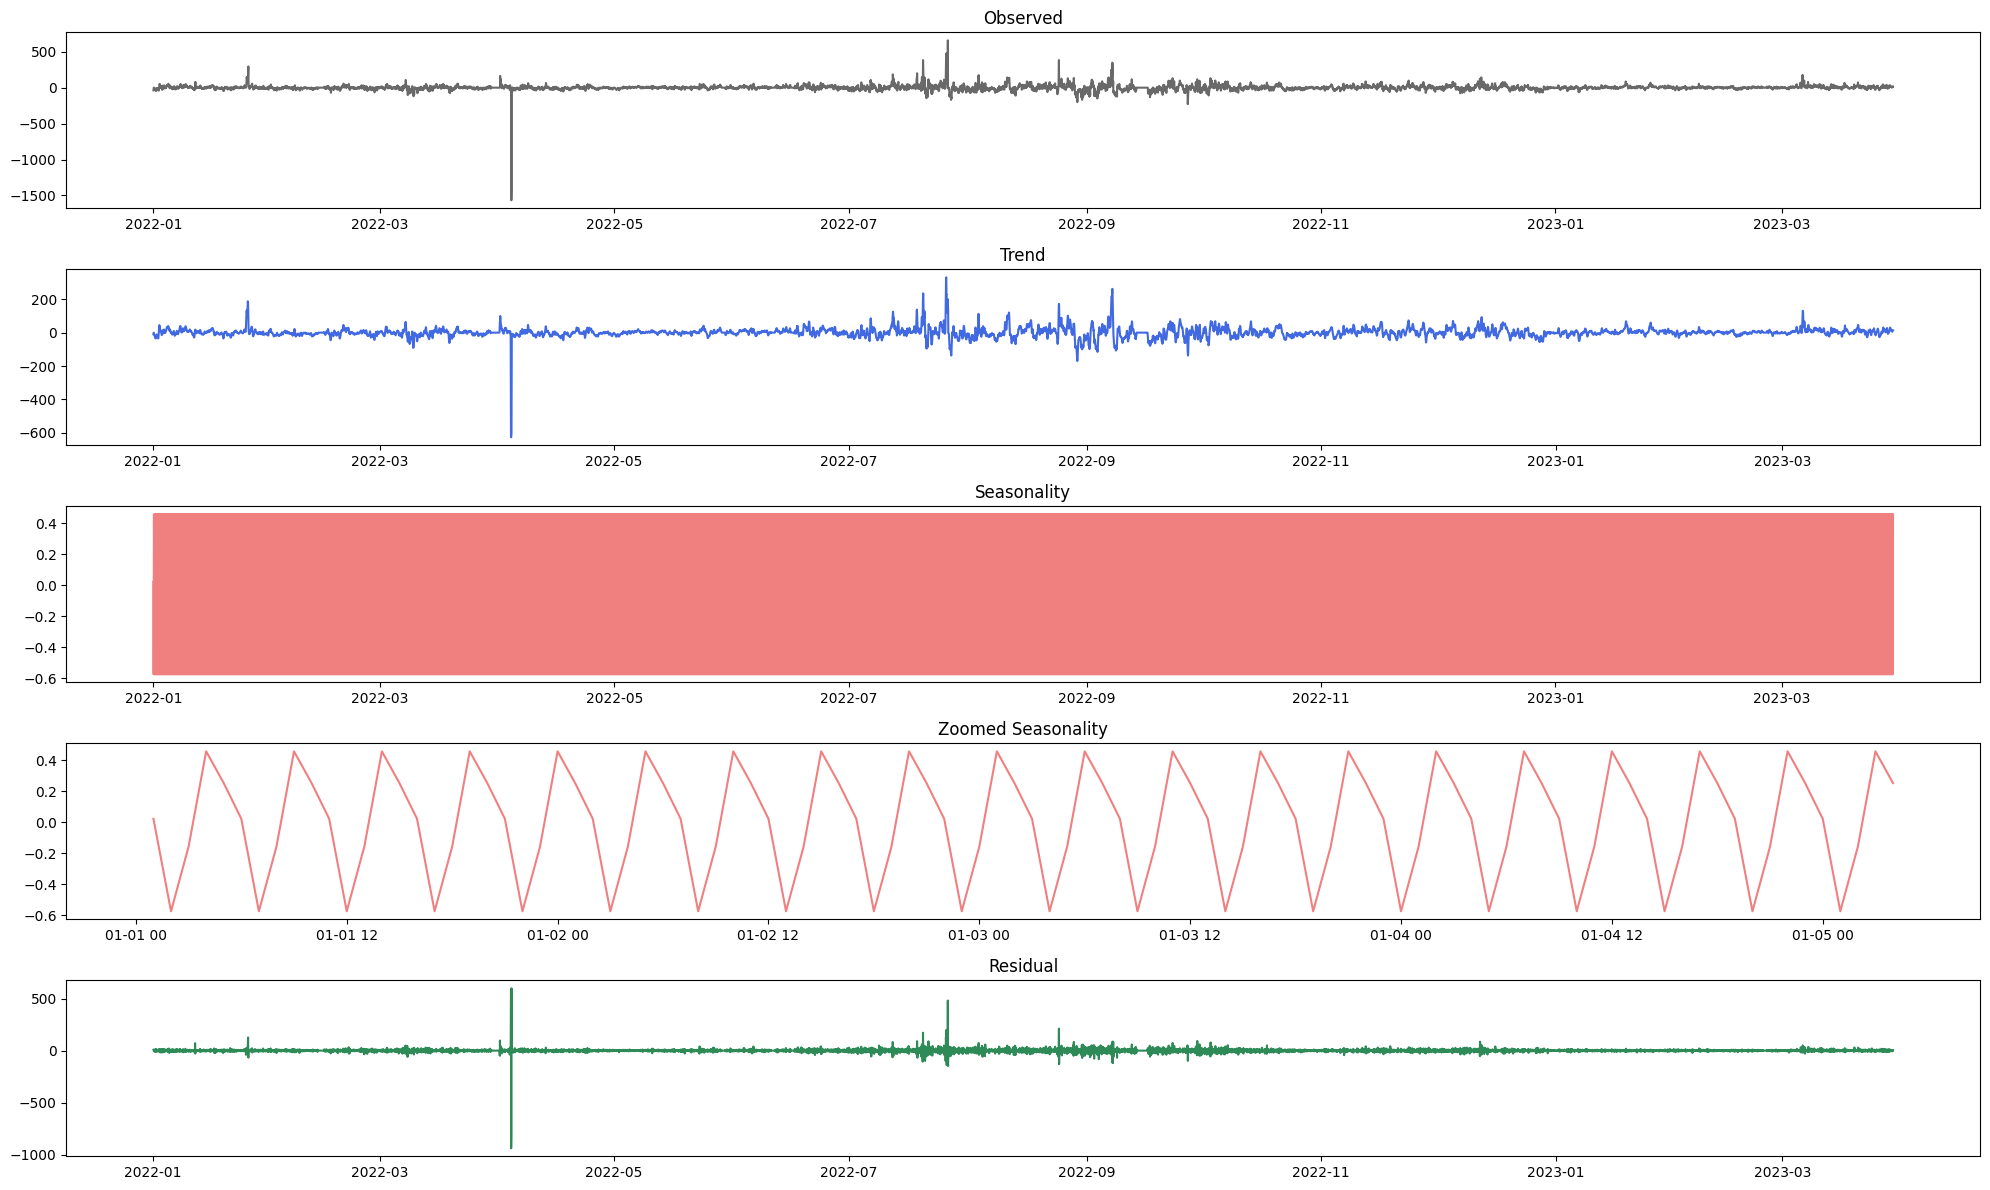

In [40]:
fig, axes = plt.subplots(5, 1, figsize=(20, 12))
decom_data = y_train_resampled[["spot_id_delta"]].copy()

decompose_result = seasonal_decompose(decom_data, period =5, model='additive')

observed    = decompose_result.observed
trend    = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

axes[0].plot(observed, color='dimgrey')
axes[0].set_title('Observed')
axes[1].plot(trend, color='royalblue')
axes[1].set_title('Trend')
axes[2].plot(seasonal, color='lightcoral')
axes[2].set_title('Seasonality')
axes[3].plot(seasonal[:100], color='lightcoral')
axes[3].set_title('Zoomed Seasonality')
axes[4].plot(residual, color='seagreen')
axes[4].set_title('Residual')

fig.tight_layout()
plt.show()


<li> <strong> The Dickey-Fuller test </strong>, also known as the Augmented Dickey-Fuller (ADF) test, is a statistical test used to 
determine whether a time series is <strong> stationary </strong> or not. Stationarity is an important concept in time series analysis
because it affects the ability to model and predict future values. The test uses a null hypothesis that the time 
series has a unit root, meaning that it is non-stationary. The alternative hypothesis is that the time series 
is stationary. The test statistic is compared to critical values from tables or computed via a statistical 
software package. If the test statistic is less than the critical value, the null hypothesis is rejected, 
and it is concluded that the time series is stationary.</li>
<p>
</p>
<li> In the context of time series analysis, stationarity refers to a property of a time series where the 
statistical properties of the series <strong> do not change over time </strong>. More specifically, a stationary time series is 
one where <strong> the mean, variance, and autocorrelation </strong> structure of the series do not depend on the time at which 
they are computed.</li>
<p>
</p>
<li>The concept of stationarity is important in time series analysis because it simplifies the modeling process and 
enables the use of statistical tools that assume stationarity, such as  <strong>ARMA</strong> (autoregressive moving average) models.
In contrast, non-stationary time series can exhibit trends, seasonality, and other systematic patterns that can 
make it difficult to model and forecast accurately.</li>


In [41]:
result = adfuller(y_train_resampled[["spot_id_delta"]])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -21.055305340511453
p-value: 0.0
Critical Values: {'1%': -3.430952454340349, '5%': -2.8618062512958002, '10%': -2.5669117204317113}


<li> So based on the comments above we can see that the ADF statistics is even lower than the p value with 1% 
significance level. So the time series is considered as stationary! </li>

<li> <strong>Autocorrelation</strong> is a measure of the linear dependence between a time series and its lagged values. It measures 
how strongly the values of a time series at one time are correlated with the values at other times. Autocorrelation 
can be positive (indicating that high values tend to be followed by high values and low values tend to be followed 
by low values) or negative (indicating that high values tend to be followed by low values and vice versa). </li>
<p>
</p>
<li> <strong>Partial autocorrelation</strong>, on the other hand, measures the linear dependence between a time series and its lagged 
values, <strong> after removing the effect of any intermediate lags </strong>. It provides a measure of the direct correlation between 
two time points, taking into account any indirect correlation through intermediate time points. Partial autocorrelation 
can help identify the <strong> order </strong> of an autoregressive (AR) model, which is a model that uses lagged values of the time series 
as predictors. </li>

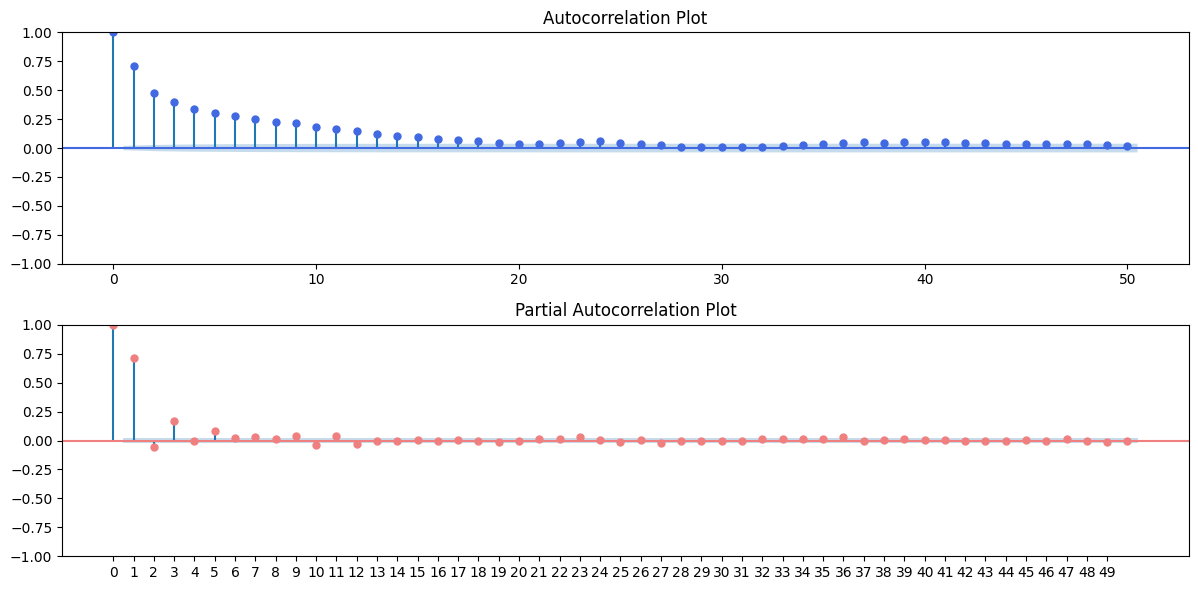

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(y_train_resampled[["spot_id_delta"]], lags=50, ax=ax[0], color='royalblue')
ax[0].set_title('Autocorrelation Plot')
plot_pacf(y_train_resampled[["spot_id_delta"]], lags=50, ax=ax[1], color='lightcoral')
ax[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.xticks(np.arange(0,50,1))
plt.show()

<li> Based on the partial autocorrolation, we have strong correlation of an observation with its past 3 values (after 3,
the correlation becomes very weak). So we use <strong> 25 </strong> lag feature for our time series! </li>

<h3> Dimensionality reduction and train-test split </h3>
<p>
</p>
<li> In this section I applied PCA for dimensionality reduction and add windowing to the dataset to make it prepared as input for tensorflow. I also split the train, validation and test sets and plot it with seperate colors in the figure. 
For faster convergnce and better performance of ML/DL models I normalzed the dataset. </li>

In [381]:
X = x_train_we
y = y_train_resampled[["spot_id_delta"]]
X_test = x_train_transition_test_we[x_train_we.shape[0]-hist_size:]


In [405]:
def apply_PCA(X_train, X_val, X_test, cum_variance, if_apply):
    
    if if_apply:
    
        pca = PCA(n_components = cum_variance)
        # make pipeline to first standardize then apply PCA on data
        scaler_pca = make_pipeline(StandardScaler(), pca)
        X_pca = scaler_pca.fit(X_train).transform(X_train)
        X_pca_val = scaler_pca.transform(X_val)
        X_pca_test = scaler_pca.transform(X_test)
        X_pca = pd.DataFrame(X_pca, index = X_train.index)
        X_pca_val = pd.DataFrame(X_pca_val, index = X_val.index)
        X_pca_test = pd.DataFrame(X_pca_test, index = X_test.index)
        return X_pca, X_pca_val, X_pca_test
    
    else:
        
        return X_train, X_val, X_test

In [422]:
train_cutoff = int(0.8*X_pca.shape[0])
val_cutoff   = int(X_pca.shape[0]-1)

params_pca = {'cum_variance' : 0.8, 'if_apply' : True }
X_pca_train, X_pca_val, X_pca_test = apply_PCA(X.iloc[:train_cutoff], X.iloc[train_cutoff:val_cutoff], X_test, **params_pca)
scaler_y = StandardScaler()
scaler_y.fit(y[:train_cutoff])
y_norm = scaler_y.transform(y)
y_norm = pd.DataFrame(y_norm, index=y.index)

In [423]:
def windowing(X_input,y_input, history_size):
    
    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data_sample = np.concatenate((np.array(X_input.iloc[i - history_size : i, :]).flatten(),X_input.iloc[i,:-1]))
        data.append(data_sample)
        labels.append(y_input[i])
    data = np.array(data)
    data = pd.DataFrame(data, index=X_input.iloc[history_size: len(y_input)].index)
    labels = np.array(labels)
    labels = labels.reshape(-1,1)
    labels = pd.DataFrame(labels, y_input.iloc[history_size: len(y_input)].index)
    return data, labels

<li> Normalizing target varialbe, since we already normalized features during the process of applying PCA! </li>

<li> hist_size is the history size equivalent to look back! </li>

In [424]:
hist_size= 2
data_train = pd.concat((X_pca_train, y_norm.iloc[:train_cutoff]), axis = 1)
data_val = pd.concat((X_pca_val, y_norm.iloc[train_cutoff: val_cutoff]), axis=1)

X_train_, y_train_ = windowing(data_train,data_train.iloc[:,-1], hist_size)
X_val_, y_val_     = windowing(data_val,data_val.iloc[:,-1], hist_size)

/tmp/ipykernel_33/1079079876.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



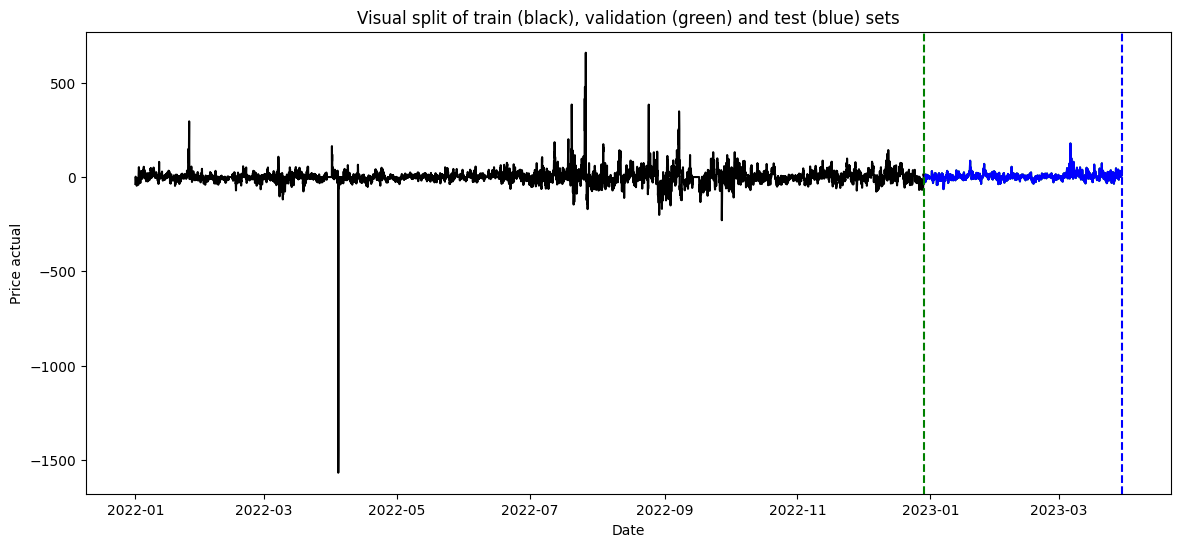

In [426]:
fig, axes = plt.subplots(figsize = (14,6))
axes.plot(y_train_resampled.iloc[:train_cutoff,0], color = 'black')
axes.plot(y_train_resampled.iloc[train_cutoff+1 : val_cutoff,0], color = 'green')
axes.plot(y_train_resampled.iloc[train_cutoff + 1 :,0], color = 'blue')
axes.axvline(x=y_train_resampled.index[train_cutoff], color='green', linestyle='--')
axes.axvline(x=y_train_resampled.index[val_cutoff], color='blue', linestyle='--')
axes.set_title('Visual split of train (black), validation (green) and test (blue) sets')
axes.set_xlabel('Date')
axes.set_ylabel('Price actual')
plt.show()

## Forecasting

<h3> 1. XGBoost </h3>

In [427]:
X_train_xgb = X_train_
X_val_xgb   = X_val_

In [428]:
xgb_model = xgb.XGBRegressor()


# the code commented below does hyperparamter tunning for XGBoost!
#-----------------------------------------
# Grid of parameters to choose from

# xgb_params = {
#     "n_estimators": [10, 50, 100],
#     "subsample":[0.6, 0.8, 1],
#     "learning_rate":[0.01, 0.1, 0.5, 1],
#     "gamma":[0.01, 0.1, 1, 5],
#     "alpha":[0, 0.1, 0.5]
# }

# grid_xgb = GridSearchCV(xgb_hp_tunning, xgb_params, cv = 3)

# grid_xgb.fit(X_train_xgb, y_train)
# xgb_best_model = grid_xgb.best_estimator_

# y_pred = xgb_best_model.predict(X_test_xgb)

# mae = mean_absolute_error(y_pred, y_test_xgb)
# print(f'Mean Absolute Error: {round(mae,3)}')
#---------------------------------------------


# Fit the model
xgb_model.fit(X_train_xgb, y_train_,
               eval_set=[(X_train_xgb, y_train_), (X_val_xgb, y_val_)],     
               eval_metric='mae',
               early_stopping_rounds=8,
               verbose=False) 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [429]:
def plot_results(y_pred_actual, y_test_inv, model, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    
    ax[0].plot(y_pred_actual[-2000:])
    ax[0].plot(y_test_inv[-2000:])
    ax[0].legend(['prediction', 'actual'], loc='upper left')
    ax[0].set_title(f'Prediction vs actual price for 1000 observation in test set ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Price')
    
    if model != 'hybrid':
    
        if model_name == 'XGBoost':

            train_mae = model.evals_result()['validation_0']['mae']
            val_mae = model.evals_result()['validation_1']['mae']
            ax[1].plot(train_mae, label='Training MAE')
            ax[1].plot(val_mae, label='Validation MAE')

        else:

            ax[1].plot(history.history['loss'], label='Training Loss')
            ax[1].plot(history.history['val_loss'], label='Validation Loss')

        ax[1].legend()
        ax[1].set_title(f'Training and validation MAE ({model_name})')
        ax[1].set_xlabel('Iteration/Epochs')
        ax[1].set_ylabel('MAE')    
        
    fig.tight_layout()
    plt.show()
    



---------------------------------------------------
XGBoost MAE for validation set : 0.15
---------------------------------------------------



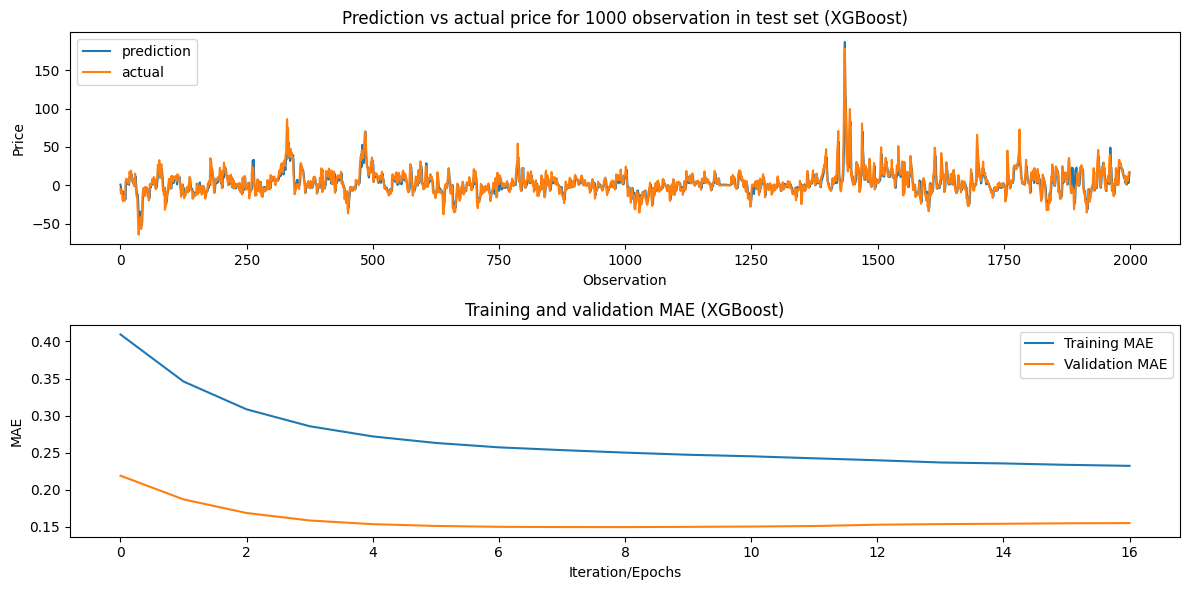

In [430]:
y_pred = xgb_model.predict(X_val_xgb) 
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_val_inv = scaler_y.inverse_transform(y_val_)


print('')
print('')
print('---------------------------------------------------')
print(f'XGBoost MAE for validation set : {round(mean_absolute_error(y_pred,y_val_),3)}')
print('---------------------------------------------------')
print('')
plot_results(y_pred_actual, y_val_inv, xgb_model,'XGBoost')

In [431]:
def weighted_accuracy(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    return np.sum(((y_true * y_pred) > 0) * np.abs(y_true)) / np.sum(np.abs(y_true))

In [432]:
weighted_accuracy(y_val_inv, y_pred_actual)

0.929419235683675

2.74377

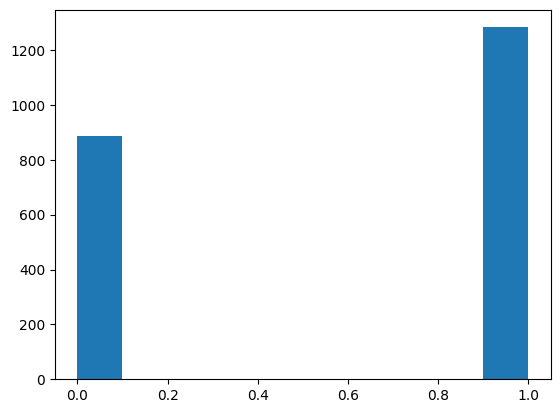

In [433]:
plt.hist((y_pred_actual>0).astype(int))
np.mean(y_pred_actual)

On test set

In [434]:
hist_size= 2
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }

#History -- initialisation
X_pca_test_new = pd.concat((X_pca_val.iloc[-hist_size:,:], X_pca_test), axis=0)
y_test = pd.DataFrame(np.zeros(X_pca_test.shape[0]), index=X_pca_test.index)
y_norm_test = pd.concat((y_val_.iloc[-hist_size:],y_test), axis=0)
data = pd.concat((X_pca_test_new,y_norm_test),axis=1)

#Sequential prediction
for i in range(hist_size, data.shape[0]):
    x = np.concatenate((np.array(data.iloc[i-hist_size:i,:]).flatten(),data.iloc[i,:-1]))
    x = pd.DataFrame(x.reshape(1,-1), index=[data.index[i]])
    data.iloc[i,-1] = xgb_model.predict(x)

In [435]:
y_pred_test = data.loc[original_x_test_indices].iloc[:,-1]
y_pred_test = pd.DataFrame(y_pred_test).rename(columns={0:'spot_id_delta'})
y_pred_test['spot_id_delta'] = scaler_y.inverse_transform(np.array(y_pred_test['spot_id_delta']).reshape(-1,1))
np.mean(y_pred_test['spot_id_delta'])

1.4580115792045079

mean 1.4580115792045079
std 4.320513728533758


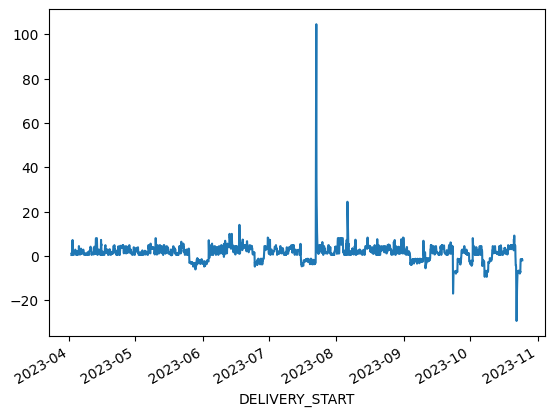

In [436]:
y_pred_test['spot_id_delta'].plot()
print('mean', np.mean(y_pred_test['spot_id_delta']))
print('std', np.std(y_pred_test['spot_id_delta']))

(array([1003.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3939.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

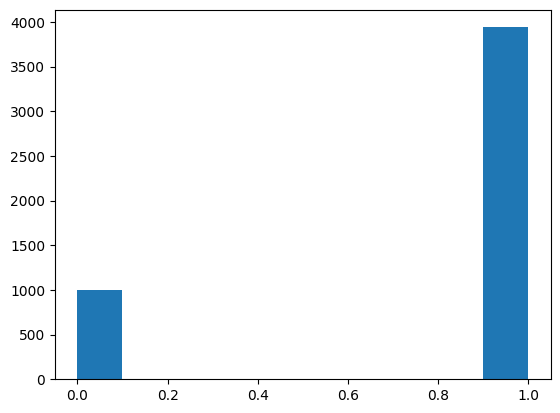

In [437]:
y_pred_test_cls = (y_pred_test['spot_id_delta']>0).astype(int)
plt.hist(y_pred_test_cls)

In [438]:
y_test_pred = (y_pred_test['spot_id_delta']>0).astype(int)*2 -1
submission = pd.DataFrame(y_test_pred, index=x_test_raw.index, columns=['spot_id_delta'])
model_name = 'XGBoost'
submission.to_csv(f'{model_name}.csv', index=True)

array([[<Axes: title={'center': 'spot_id_delta'}>]], dtype=object)

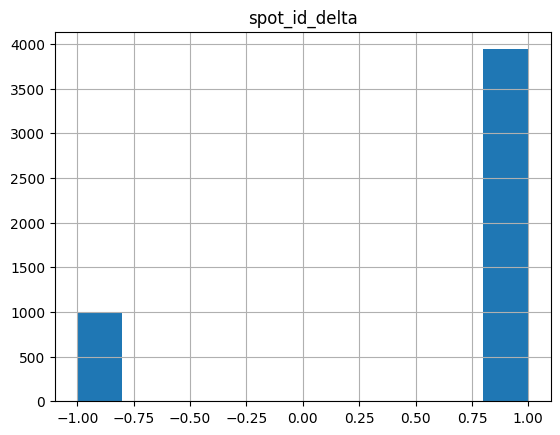

In [439]:
submission.hist()

<h3> 2. GRU </h3>

In [331]:
def base_model_gru():
    
    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, activation="relu", input_shape=X_train_.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    return model

gru_model = base_model_gru()


In [332]:
# inputs for DL models
epoch = 100
batch_size = 64
steps_per_epoch = len(X_train_) // batch_size
cyclic_lr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-04,
                                                maximal_learning_rate=1e-02,
                                                scale_fn=lambda x: 1/(2**(x-1)),
                                                step_size=6 * steps_per_epoch)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
optimizer = Adam(learning_rate=cyclic_lr, amsgrad=True)

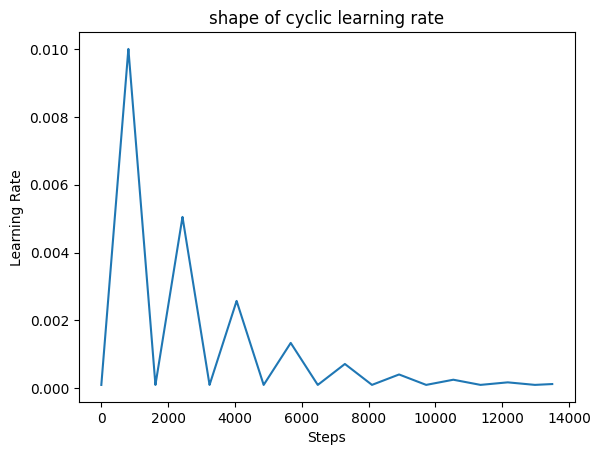

In [333]:
step = np.arange(0, epoch * steps_per_epoch)
lr = cyclic_lr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("shape of cyclic learning rate")
plt.show()


In [334]:
gru_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
history = gru_model.fit(X_train_, y_train_, validation_data = (X_val_, y_val_), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 8693, 23), found shape=(None, 23)


109/109 [==============================] - 0s 3ms/step





---------------------------------------------------

GRU MAE for test set : 0.015

---------------------------------------------------




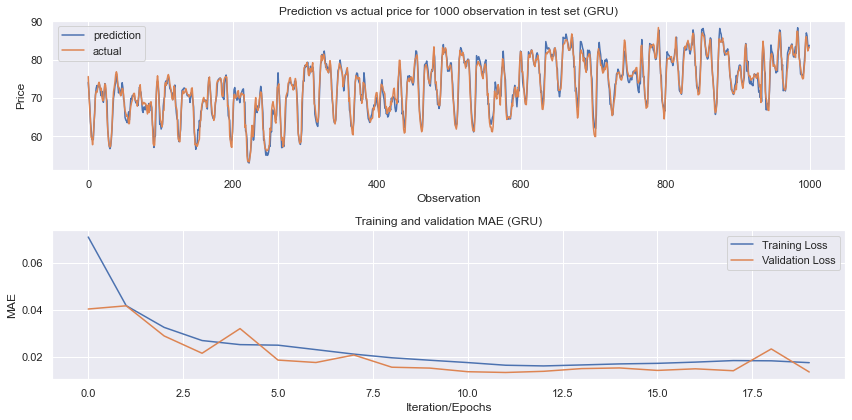

In [250]:
y_pred = gru_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'GRU MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'GRU')

<h3> 3. LSTM </h3>

In [142]:
def base_model_lstm():

    model = Sequential()
    model.add(LSTM(units = 32, return_sequences = True, activation="relu", input_shape = X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    return model

lstm_model = base_model_lstm()
lstm_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
lstm_model.summary()

Model: "sequential_18"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 lstm_7 (LSTM)               (None, 24, 32)            6272      

                                                                 

 flatten_17 (Flatten)        (None, 768)               0         

                                                                 

 dense_34 (Dense)            (None, 128)               98432     

                                                                 

 dropout_2 (Dropout)         (None, 128)               0         

                                                                 

 dense_35 (Dense)            (None, 1)                 129       

                                                                 


Total params: 104,833

Trainable params: 104,833

Non-trainable params: 0

_________________________________________________________________


In [143]:
history = lstm_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs =epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100

438/438 [==============================] - 6s 10ms/step - loss: 0.0807 - val_loss: 0.0727

Epoch 2/100

438/438 [==============================] - 4s 10ms/step - loss: 0.0416 - val_loss: 0.0334

Epoch 3/100

438/438 [==============================] - 4s 10ms/step - loss: 0.0316 - val_loss: 0.0235

Epoch 4/100

438/438 [==============================] - 4s 10ms/step - loss: 0.0274 - val_loss: 0.0225

Epoch 5/100

438/438 [==============================] - 4s 10ms/step - loss: 0.0254 - val_loss: 0.0209

Epoch 6/100

438/438 [==============================] - 4s 10ms/step - loss: 0.0247 - val_loss: 0.0190

Epoch 7/100

438/438 [==============================] - 4s 10ms/step - loss: 0.0240 - val_loss: 0.0192

Epoch 8/100

438/438 [==============================] - 4s 10ms/step - loss: 0.0230 - val_loss: 0.0192

Epoch 9/100

438/438 [==============================] - 4s 10ms/step - loss: 0.0228 - val_loss: 0.0185

Epoch 10/100

438/438 [==============================] - 4s 10ms

109/109 [==============================] - 1s 3ms/step





---------------------------------------------------

LSTM MAE for test set : 0.018

---------------------------------------------------




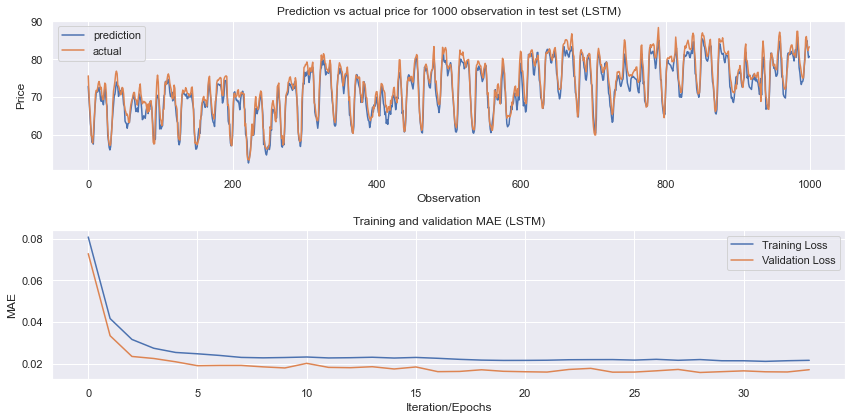

In [144]:
y_pred = lstm_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM')

<h3> 4. CNN </h3>

In [145]:
def base_model_cnn():
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    return model

cnn_model = base_model_cnn()
cnn_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
cnn_model.summary()

Model: "sequential_19"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv1d_13 (Conv1D)          (None, 22, 32)            1568      

                                                                 

 flatten_18 (Flatten)        (None, 704)               0         

                                                                 

 dense_36 (Dense)            (None, 128)               90240     

                                                                 

 dropout_3 (Dropout)         (None, 128)               0         

                                                                 

 dense_37 (Dense)            (None, 1)                 129       

                                                                 


Total params: 91,937

Trainable params: 91,937

Non-trainable params: 0

_________________________________________________________________


In [146]:
history = cnn_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100

438/438 [==============================] - 2s 4ms/step - loss: 0.0636 - val_loss: 0.0425

Epoch 2/100

438/438 [==============================] - 1s 3ms/step - loss: 0.0428 - val_loss: 0.0378

Epoch 3/100

438/438 [==============================] - 1s 3ms/step - loss: 0.0377 - val_loss: 0.0308

Epoch 4/100

438/438 [==============================] - 1s 3ms/step - loss: 0.0343 - val_loss: 0.0302

Epoch 5/100

438/438 [==============================] - 1s 3ms/step - loss: 0.0315 - val_loss: 0.0250

Epoch 6/100

438/438 [==============================] - 1s 3ms/step - loss: 0.0296 - val_loss: 0.0260

Epoch 7/100

438/438 [==============================] - 1s 3ms/step - loss: 0.0282 - val_loss: 0.0252

Epoch 8/100

438/438 [==============================] - 1s 3ms/step - loss: 0.0266 - val_loss: 0.0266

Epoch 9/100

438/438 [==============================] - 1s 3ms/step - loss: 0.0255 - val_loss: 0.0249

Epoch 10/100

438/438 [==============================] - 1s 3ms/step - lo

109/109 [==============================] - 0s 1ms/step





---------------------------------------------------

CNN MAE for test set : 0.025

---------------------------------------------------




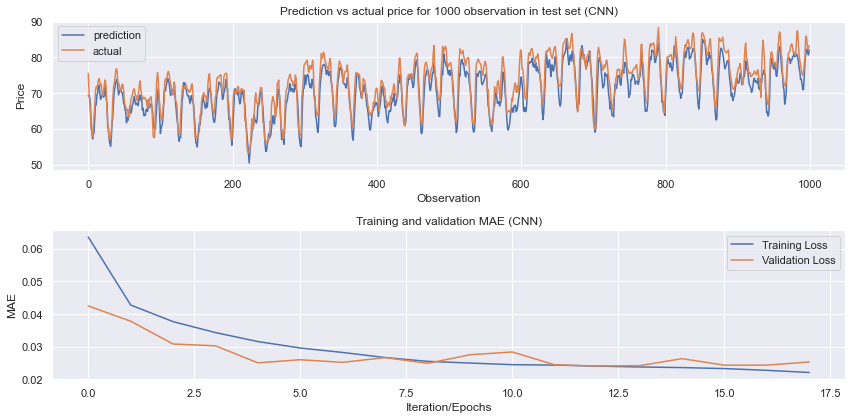

In [147]:
y_pred = cnn_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'CNN MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'CNN')

<h3> 5. CNN-LSTM </h3>

In [224]:
def base_model_cnn_lstm():
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_train.shape[-2:]))
    model.add(LSTM(units = 8, return_sequences = True, activation="relu"))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    
    return model

cnn_lstm_model = base_model_cnn_lstm()
cnn_lstm_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
cnn_lstm_model.summary()

Model: "sequential_23"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv1d_14 (Conv1D)          (None, 22, 64)            3136      

                                                                 

 lstm_10 (LSTM)              (None, 22, 8)             2336      

                                                                 

 flatten_25 (Flatten)        (None, 176)               0         

                                                                 

 dense_50 (Dense)            (None, 256)               45312     

                                                                 

 dense_51 (Dense)            (None, 1)                 257       

                                                                 


Total params: 51,041

Trainable params: 51,041

Non-trainable params: 0

_________________________________________________________________


In [225]:
history = cnn_lstm_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100

438/438 [==============================] - 5s 9ms/step - loss: 0.0584 - val_loss: 0.0615

Epoch 2/100

438/438 [==============================] - 4s 9ms/step - loss: 0.0333 - val_loss: 0.0382

Epoch 3/100

438/438 [==============================] - 4s 8ms/step - loss: 0.0287 - val_loss: 0.0339

Epoch 4/100

438/438 [==============================] - 4s 8ms/step - loss: 0.0253 - val_loss: 0.0239

Epoch 5/100

438/438 [==============================] - 4s 8ms/step - loss: 0.0228 - val_loss: 0.0225

Epoch 6/100

438/438 [==============================] - 4s 8ms/step - loss: 0.0208 - val_loss: 0.0202

Epoch 7/100

438/438 [==============================] - 4s 8ms/step - loss: 0.0195 - val_loss: 0.0188

Epoch 8/100

438/438 [==============================] - 4s 8ms/step - loss: 0.0181 - val_loss: 0.0209

Epoch 9/100

438/438 [==============================] - 4s 8ms/step - loss: 0.0173 - val_loss: 0.0184

Epoch 10/100

438/438 [==============================] - 4s 8ms/step - lo

109/109 [==============================] - 0s 3ms/step





---------------------------------------------------

CNN-LSTM MAE for test set : 0.019

---------------------------------------------------




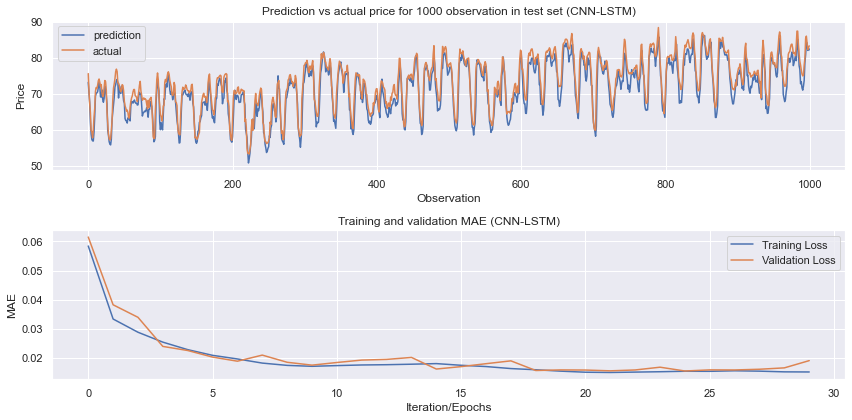

In [227]:
y_pred = cnn_lstm_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'CNN-LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'CNN-LSTM')

<h3> 6. LSTM-Attention </h3>

In [208]:
def LSTM_attention():
    inputs = Input(shape=(hist_size, X_train.shape[2]))
    #By masking the zeros, the model can learn to ignore the missing values and focus on the valid data.
    masked = Masking(mask_value=0.)(inputs)
    lstm = LSTM(132, return_sequences=True)(masked)
    attention = dot([lstm, lstm], axes=[2, 2])
    # extracting weight for every observation in the history size!
    attention = Dense(hist_size, activation='softmax')(attention)
    # assinging weight to lstm by dot product
    context = dot([attention, lstm], axes=[2, 1])
    flattened = Flatten()(context)8
    output = Dense(1)(flattened)
    model = Model(inputs=inputs, outputs=output)
    
    return model

LSTM_attention_model = LSTM_attention()
LSTM_attention_model.compile(optimizer=optimizer, loss='mae')
LSTM_attention_model.summary()


Model: "model_2"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_4 (InputLayer)           [(None, 24, 16)]     0           []                               

                                                                                                  

 masking_3 (Masking)            (None, 24, 16)       0           ['input_4[0][0]']                

                                                                                                  

 lstm_9 (LSTM)                  (None, 24, 132)      78672       ['masking_3[0][0]']              

                                                                                                  

 dot_6 (Dot)                    (None, 24, 24)       0           ['lstm_9[0][0]',                 

                                                                  'lstm_9[0][0]']

In [149]:
history = LSTM_attention_model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

Epoch 1/100

438/438 [==============================] - 17s 32ms/step - loss: 0.0517 - val_loss: 0.0314

Epoch 2/100

438/438 [==============================] - 13s 29ms/step - loss: 0.0333 - val_loss: 0.0287

Epoch 3/100

438/438 [==============================] - 13s 29ms/step - loss: 0.0294 - val_loss: 0.0272

Epoch 4/100

438/438 [==============================] - 13s 30ms/step - loss: 0.0266 - val_loss: 0.0235

Epoch 5/100

438/438 [==============================] - 13s 30ms/step - loss: 0.0245 - val_loss: 0.0230

Epoch 6/100

438/438 [==============================] - 13s 30ms/step - loss: 0.0231 - val_loss: 0.0241

Epoch 7/100

438/438 [==============================] - 13s 29ms/step - loss: 0.0222 - val_loss: 0.0207

Epoch 8/100

438/438 [==============================] - 13s 29ms/step - loss: 0.0216 - val_loss: 0.0216

Epoch 9/100

438/438 [==============================] - 13s 30ms/step - loss: 0.0214 - val_loss: 0.0187

Epoch 10/100

438/438 [==============================] 

109/109 [==============================] - 2s 9ms/step





---------------------------------------------------

LSTM-Attention MAE for test set : 0.015

---------------------------------------------------




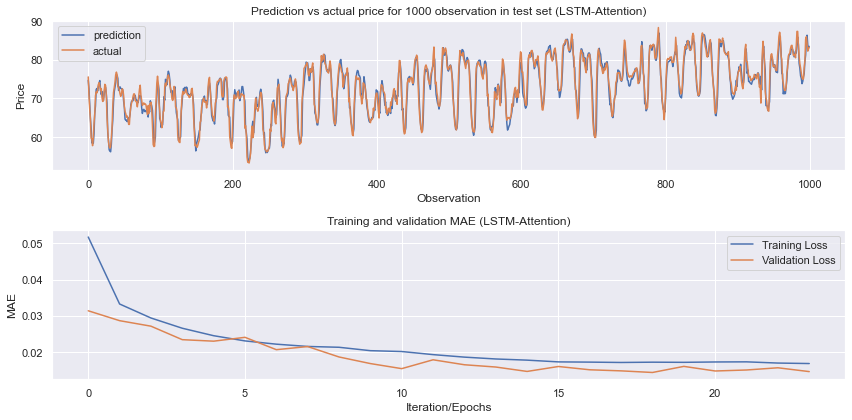

In [151]:
y_pred = LSTM_attention_model.predict(X_test)
print('')
print('')

print('---------------------------------------------------')
print(f'LSTM-Attention MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM-Attention')

<h3> 7. Hybrid GRU-XGBoost </h3>

In [266]:
def base_model_gru():
    
    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, activation="relu", input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    return model

gru_model = base_model_gru()
gru_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')

print('')
print('GRU is fitting a model on train-validation sets...')
print('')

gru_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

print('')
print('----------------------------------')
print('GRU is predicting...')
print('')

residuals_train = y_train - gru_model.predict(X_train)
residuals_val   = y_val - gru_model.predict(X_val)

print('')
print('----------------------------------')
print('XGBoost is fitting a model on residuals...')
print('')

xgb_hybrid = xgb.XGBRegressor()
xgb_hybrid.fit(X_train_xgb, residuals_train,
               eval_set=[(X_train_xgb, residuals_train), (X_val_xgb, residuals_val)],     
               eval_metric='mae',
               early_stopping_rounds=8,
               verbose=False) 


y_train_pred = gru_model.predict(X_train) + xgb_hybrid.predict(X_train_xgb).reshape(-1,1)
y_val_pred   = gru_model.predict(X_val)   + xgb_hybrid.predict(X_val_xgb).reshape(-1,1)



GRU is fitting a model on train-validation sets...



Epoch 1/100

438/438 [==============================] - 5s 10ms/step - loss: 0.0701 - val_loss: 0.0486

Epoch 2/100

438/438 [==============================] - 4s 9ms/step - loss: 0.0413 - val_loss: 0.0371

Epoch 3/100

438/438 [==============================] - 4s 9ms/step - loss: 0.0322 - val_loss: 0.0235

Epoch 4/100

438/438 [==============================] - 4s 9ms/step - loss: 0.0259 - val_loss: 0.0296

Epoch 5/100

438/438 [==============================] - 4s 9ms/step - loss: 0.0241 - val_loss: 0.0236

Epoch 6/100

438/438 [==============================] - 4s 9ms/step - loss: 0.0236 - val_loss: 0.0196

Epoch 7/100

438/438 [==============================] - 4s 9ms/step - loss: 0.0226 - val_loss: 0.0174

Epoch 8/100

438/438 [==============================] - 4s 9ms/step - loss: 0.0208 - val_loss: 0.0159

Epoch 9/100

438/438 [==============================] - 4s 9ms/step - loss: 0.0196 - val_loss: 0.0177

Epoch 10/100

43

109/109 [==============================] - 0s 3ms/step





---------------------------------------------------

GRU-XGBoost MAE for test set : 0.014

---------------------------------------------------




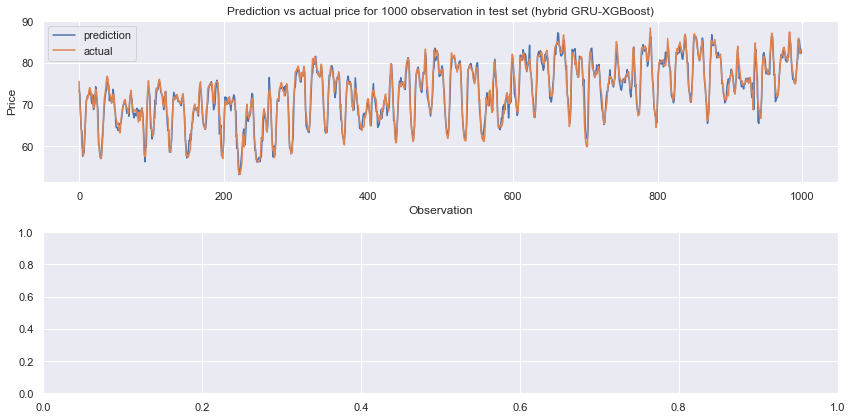

In [267]:
y_test_pred  = gru_model.predict(X_test) + xgb_hybrid.predict(X_test_xgb).reshape(-1,1)
print('')
print('')

print('---------------------------------------------------')
print(f'GRU-XGBoost MAE for test set : {round(mean_absolute_error(y_test_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_test_pred)
print('')
plot_results(y_pred_actual, y_test_inv, 'hybrid' ,'hybrid GRU-XGBoost')


<h3> 8. Hybrid LSTM-Attention-XGBoost </h3>

In [269]:
def LSTM_attention():
    inputs = Input(shape=(hist_size, X_train.shape[2]))
    #By masking the zeros, the model can learn to ignore the missing values and focus on the valid data.
    masked = Masking(mask_value=0.)(inputs)
    lstm = LSTM(132, return_sequences=True)(masked)
    attention = dot([lstm, lstm], axes=[2, 2])
    # extracting weight for every observation in the history size!
    attention = Dense(hist_size, activation='softmax')(attention)
    # assinging weight to lstm by dot product
    context = dot([attention, lstm], axes=[2, 1])
    flattened = Flatten()(context)
    output = Dense(1)(flattened)
    model = Model(inputs=inputs, outputs=output)
    
    return model

LSTM_attention_model = LSTM_attention()
LSTM_attention_model.compile(optimizer=optimizer, loss='mae')


print('')
print('LSTM-Attention is fitting a model on train-validation sets...')
print('')

LSTM_attention_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

print('')
print('----------------------------------')
print('LSTM-attention is predicting...')
print('')

residuals_train = y_train - LSTM_attention_model.predict(X_train)
residuals_val   = y_val - LSTM_attention_model.predict(X_val)

print('')
print('----------------------------------')
print('XGBoost is fitting a model on residuals...')
print('')

xgb_hybrid = xgb.XGBRegressor()
xgb_hybrid.fit(X_train_xgb, residuals_train,
               eval_set=[(X_train_xgb, residuals_train), (X_val_xgb, residuals_val)],     
               eval_metric='mae',
               early_stopping_rounds=8,
               verbose=False) 


y_train_pred = LSTM_attention_model.predict(X_train) + xgb_hybrid.predict(X_train_xgb).reshape(-1,1)
y_val_pred   = LSTM_attention_model.predict(X_val)   + xgb_hybrid.predict(X_val_xgb).reshape(-1,1)



LSTM-Attention is fitting a model on train-validation sets...



Epoch 1/100

438/438 [==============================] - 21s 37ms/step - loss: 0.0692 - val_loss: 0.0362

Epoch 2/100

438/438 [==============================] - 15s 35ms/step - loss: 0.0400 - val_loss: 0.0286

Epoch 3/100

438/438 [==============================] - 15s 34ms/step - loss: 0.0289 - val_loss: 0.0189

Epoch 4/100

438/438 [==============================] - 15s 34ms/step - loss: 0.0255 - val_loss: 0.0219

Epoch 5/100

438/438 [==============================] - 15s 34ms/step - loss: 0.0225 - val_loss: 0.0161

Epoch 6/100

438/438 [==============================] - 15s 34ms/step - loss: 0.0249 - val_loss: 0.0232

Epoch 7/100

438/438 [==============================] - 15s 34ms/step - loss: 0.0212 - val_loss: 0.0161

Epoch 8/100

438/438 [==============================] - 15s 34ms/step - loss: 0.0195 - val_loss: 0.0169

Epoch 9/100

438/438 [==============================] - 15s 34ms/step - loss: 0.0186 - val_lo

109/109 [==============================] - 1s 9ms/step





---------------------------------------------------

LSTM-Attention-XGBoost MAE for test set : 0.015

---------------------------------------------------




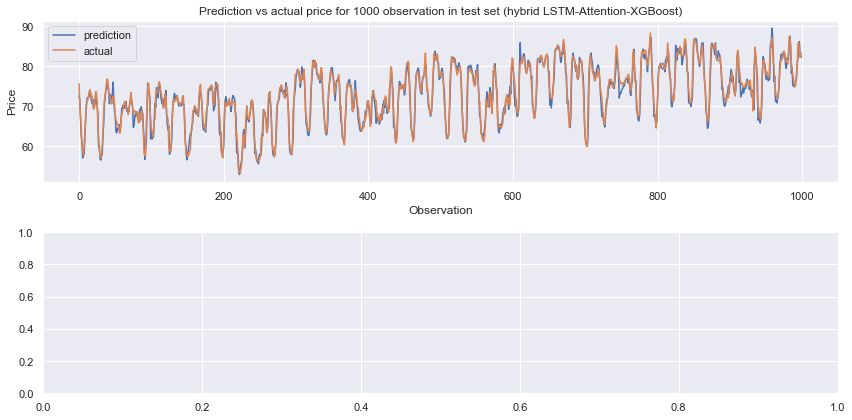

In [270]:
y_test_pred  = LSTM_attention_model.predict(X_test) + xgb_hybrid.predict(X_test_xgb).reshape(-1,1)
print('')
print('')

print('---------------------------------------------------')
print(f'LSTM-Attention-XGBoost MAE for test set : {round(mean_absolute_error(y_test_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_test_pred)
print('')
plot_results(y_pred_actual, y_test_inv, 'hybrid' ,'hybrid LSTM-Attention-XGBoost')

<h3> Results </h3>
<p>
</p>
The MAE (Mean Absolute Error) is used to report the results for the normalized test set: 
<p>
</p>    
<ul>    
<li> TSO prediction          : 0.070 </li>
<li> XGboost                 : 0.016 </li>
<li> GRU                     : 0.015 </li>
<li> LSTM                    : 0.018 </li>
<li> CNN                     : 0.025 </li>
<li> CNN-LSTM                : 0.019 </li>
<li> LSTM-Attention          : 0.015 </li>
<li> Hybrid GRU-XGBoost             : 0.014 </li>
<li> Hybrid LSTM-Attention-XGBoost  : 0.015 </li>    
</ul>

<strong> Note : </strong> According to the findings, the <strong> hybrid methods</strong> demonstrated better performance in terms of MAE compared to 
other methods. It is worth mentioning that all machine learning/deep learning methods outperformed TSO prediction.